# Load data

In [1]:
from utils import read_EHG, read_EMR
emr = read_EMR.read_EMR('dataset')
ehg = read_EHG.read_EHG('dataset')

g:\Sinh_non\Sinh_non\utils\read_EMR.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bleeding_first_trimester']=df['Bleeding_first_trimester'].replace({'yes':1,'no':0})
g:\Sinh_non\Sinh_non\utils\read_EMR.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bleeding_second_trimester']=df['Bleeding_second_trimester'].replace({'yes':1,'no':0})
g:\Sinh_non\Sinh_non\utils\read_EMR.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, expli

In [2]:
import numpy as np
X_ehg = np.array(ehg[-1])
X_emr = np.array(emr[1])
y_binary = np.array(ehg[0])[:, 0]
y_regression = np.array(ehg[0])[:, 1].reshape(-1, 1)

# Utils

In [3]:
import matplotlib.pyplot as plt

def visualize(history):
    plt.figure(figsize=(20,12))
    # Accuracy
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2,2,2)
    plt.plot(history.history['precision'], label='Train Prec')
    plt.plot(history.history['val_precision'], label='Val Prec')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2,2,3)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def visualize2(history):
    plt.figure(figsize=(20,12))
    # Accuracy
    plt.subplot(2,2,1)
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Val MSE')
    plt.title('MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # Precision
    plt.subplot(2,2,2)
    plt.plot(history.history['mae'], label='Train Mae')
    plt.plot(history.history['val_mae'], label='Val Mae')
    plt.title('MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Binary classification

## Split data

In [4]:
import keras

from sklearn.model_selection import train_test_split
y_binary = keras.utils.to_categorical(y_binary, num_classes=2)

X_ehg_train, X_ehg_test, y_ehg_train, y_ehg_test = train_test_split(X_ehg, y_binary, test_size=0.2, random_state=42)
X_emr_train, X_emr_test, y_emr_train, y_emr_test = train_test_split(X_emr, y_binary, test_size=0.2, random_state=42)


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_emr_train = scaler.fit_transform(X_emr_train)
X_emr_test = scaler.transform(X_emr_test)

## TCN: temporal convolution neural

In [6]:
from keras import layers, Model


class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, dilation_rate=1, dropout=0.0, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout

        # conv layers (causal padding)
        self.conv1 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.drop1 = layers.Dropout(dropout) if dropout > 0 else None

        self.conv2 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.drop2 = layers.Dropout(dropout) if dropout > 0 else None

        # residual add + final activation
        self.add_layer = layers.Add()
        self.final_act = layers.ReLU()

        # downsample will be created in build() only if needed
        self.downsample = None

    def build(self, input_shape):
        # input_shape: (batch, time, channels_in)
        channels_in = int(input_shape[-1])
        if channels_in != self.filters:
            # create 1x1 conv to match channels
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding="same", use_bias=False)
        else:
            # identity function (lambda)
            self.downsample = lambda x: x
        super().build(input_shape)

    def call(self, x, training=None):
        y = self.conv1(x)
        y = self.bn1(y, training=training)
        y = self.act1(y)
        if self.drop1 is not None:
            y = self.drop1(y, training=training)

        y = self.conv2(y)
        y = self.bn2(y, training=training)
        y = self.act2(y)
        if self.drop2 is not None:
            y = self.drop2(y, training=training)

        # residual path: downsample(x) if needed, else identity
        res = self.downsample(x)  # either a Layer or a lambda identity

        out = self.add_layer([res, y])
        return self.final_act(out)


class MultiInputModelTCN(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # TCN branch for time series
        self.tcn1 = TCNBlock(filters=8, kernel_size=3, dilation_rate=1, dropout=0.1)
        self.tcn2 = TCNBlock(filters=16, kernel_size=3, dilation_rate=2, dropout=0.1)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.ts_dense = layers.Dense(16, activation="relu")

        # Tabular branch (MLP)
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # Combined MLP
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # TCN branch
        x1 = self.tcn1(ts_input, training=training)
        x1 = self.tcn2(x1, training=training)
        x1 = self.global_pool(x1)   # -> (batch, channels)
        x1 = self.ts_dense(x1)

        # Tabular branch
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # Combine
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
    def build(self, input_shape):
        super().build(input_shape)


In [ ]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, Callback

# Hàm scheduler
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.6
    return lr

# Callback để log lr mỗi epoch
class LrLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr_obj = self.model.optimizer.learning_rate
        if hasattr(lr_obj, 'numpy'):
            lr = float(lr_obj.numpy())
        else:
            lr = float(tf.keras.backend.get_value(lr_obj))
        print(f"Epoch {epoch+1}: lr = {lr:.6f}")

lr_callback = LearningRateScheduler(scheduler, verbose=1)
log_callback = LrLogger()

In [8]:
model = MultiInputModelTCN(num_classes=2)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", "precision", "recall"])

In [ ]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    callbacks=[lr_callback, log_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.2188 - loss: 0.8692 - precision: 0.2188 - recall: 0.2188Epoch 1: lr = 0.001000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.1811 - loss: 0.8337 - precision: 0.1811 - recall: 0.1811 - val_accuracy: 0.3125 - val_loss: 0.7313 - val_precision: 0.3125 - val_recall: 0.3125 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3438 - loss: 0.7284 - precision: 0.3438 - recall: 0.3438Epoch 2: lr = 0.001000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2126 - loss: 0.7399 - precision: 0.2126 - recall: 0.2126 - val_accuracy: 0.3750 - val_loss: 0.7056 - val_precision: 0.3750 - val_recall: 0.3750 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
1/4 ━━━━━━━━━━━━━━━━━━

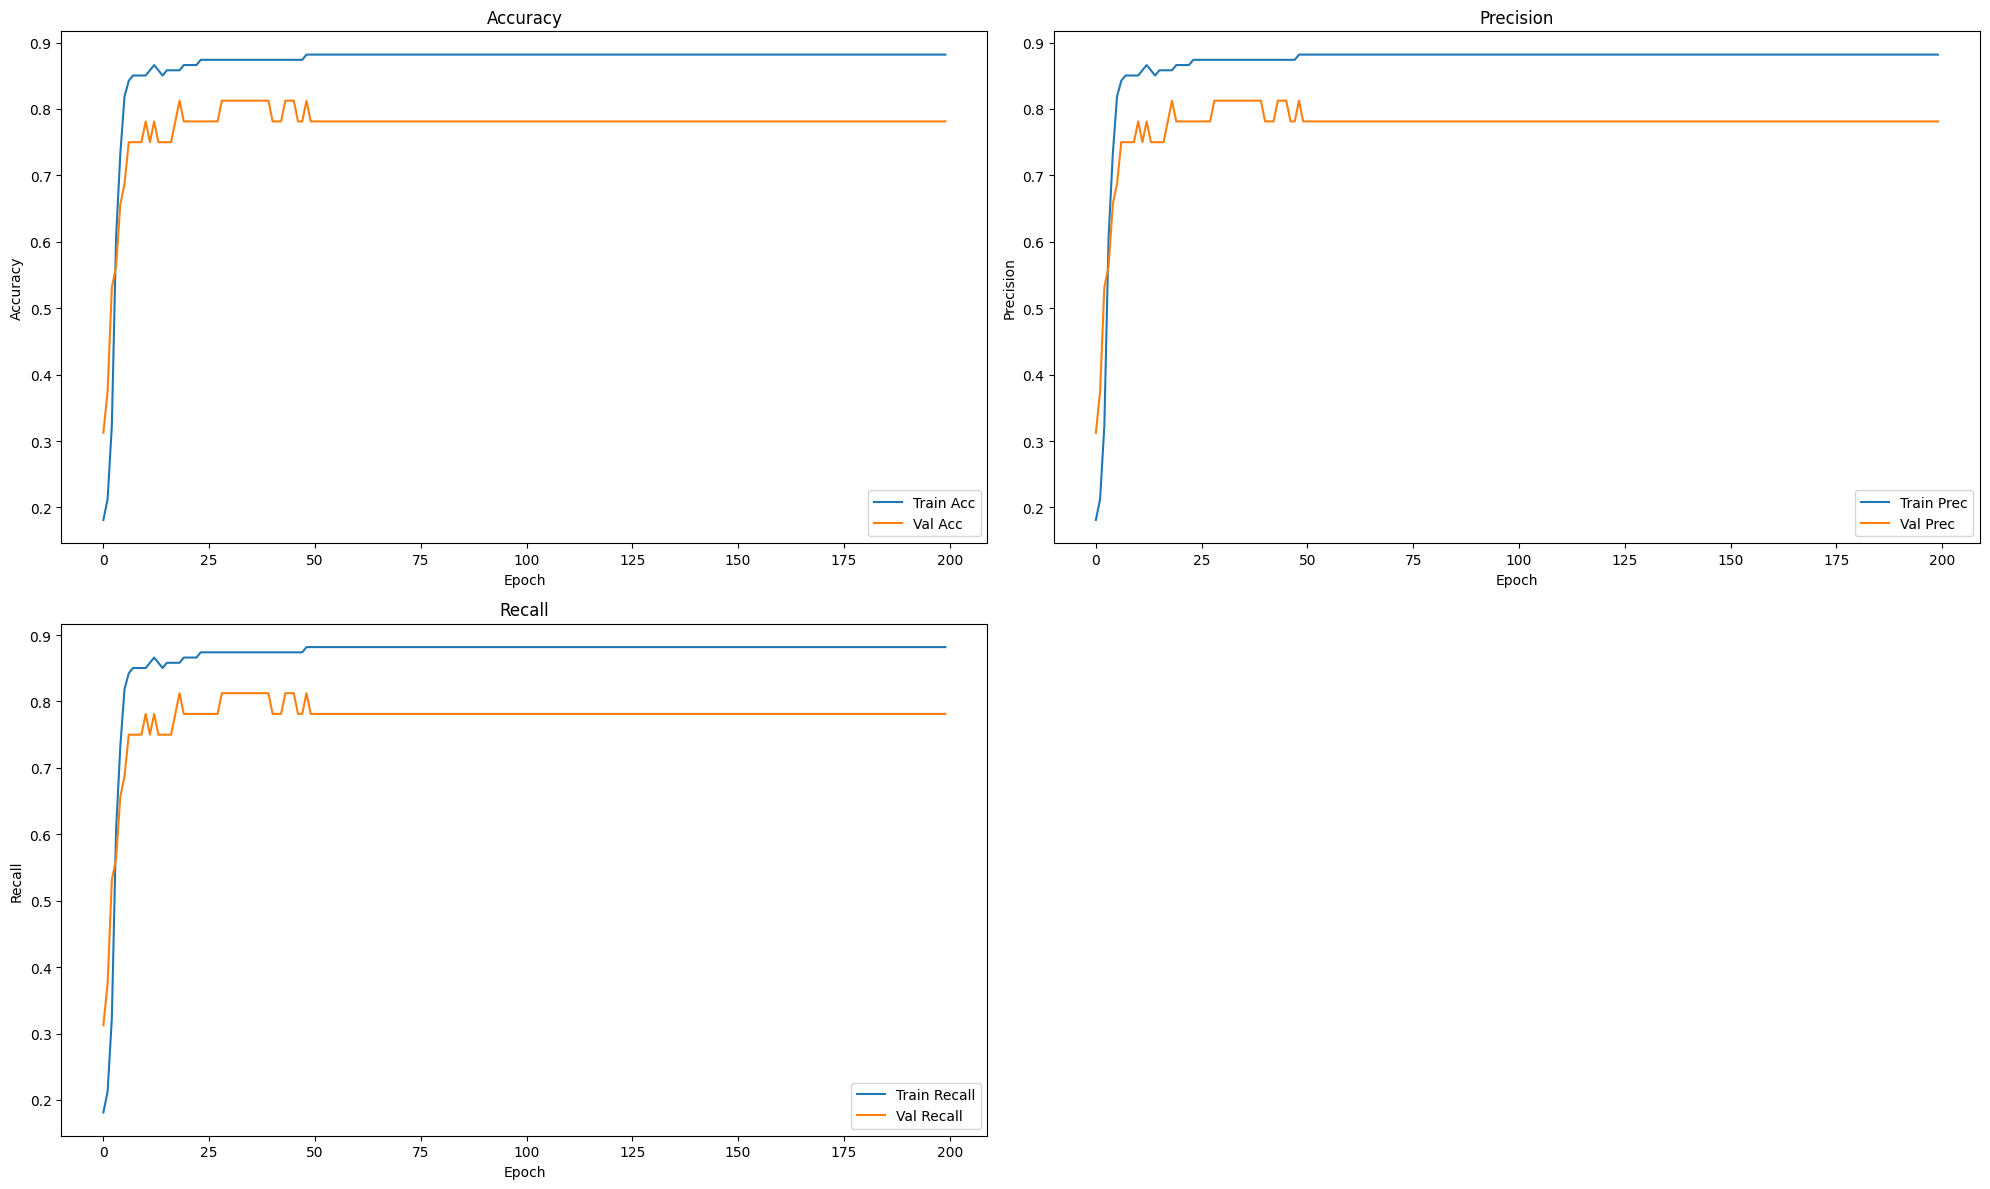

In [10]:
visualize(history= history)

## biLSTM

In [11]:
from keras import layers, Model
class BiLSTMBlock(layers.Layer):
    def __init__(self, units, dropout=0.0, return_sequences=True, name=None):
        super().__init__(name=name)
        self.units = units
        self.dropout_rate = dropout
        self.return_sequences = return_sequences

        # Bidirectional wrapper
        self.bilstm = layers.Bidirectional(
            layers.LSTM(units, dropout=dropout, return_sequences=return_sequences)
        )
        self.act = layers.ReLU()

    def call(self, x, training=None):
        y = self.bilstm(x, training=training)
        y = self.act(y)
        return y


class MultiInputModelLSTM(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # ======== BiLSTM branch for time series ========
        self.bilstm1 = BiLSTMBlock(units=32, dropout=0.1, return_sequences=True)
        self.bilstm2 = BiLSTMBlock(units=16, dropout=0.2, return_sequences=False)
        self.ts_dense = layers.Dense(16, activation="relu")

        # ======== Tabular branch (MLP) ========
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # ======== Combined MLP ========
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # --- Time series branch (BiLSTM) ---
        x1 = self.bilstm1(ts_input, training=training)
        x1 = self.bilstm2(x1, training=training)
        x1 = self.ts_dense(x1)

        # --- Tabular branch ---
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # --- Combine two branches ---
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)

    def build(self, input_shape):
        super().build(input_shape)


In [12]:
model = MultiInputModelLSTM(num_classes=2)
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy", "precision", 'recall'])

In [ ]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    callbacks=[lr_callback, log_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6647 - loss: 0.6707 - precision: 0.6647 - recall: 0.6647Epoch 1: lr = 0.001000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.6535 - loss: 0.6694 - precision: 0.6535 - recall: 0.6535 - val_accuracy: 0.6250 - val_loss: 0.6267 - val_precision: 0.6250 - val_recall: 0.6250 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8408 - loss: 0.5893 - precision: 0.8408 - recall: 0.8408Epoch 2: lr = 0.001000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8110 - loss: 0.5891 - precision: 0.8110 - recall: 0.8110 - val_accuracy: 0.8125 - val_loss: 0.5751 - val_precision: 0.8125 - val_recall: 0.8125 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
3/4 ━━━━━━━━━━━━━━━━━

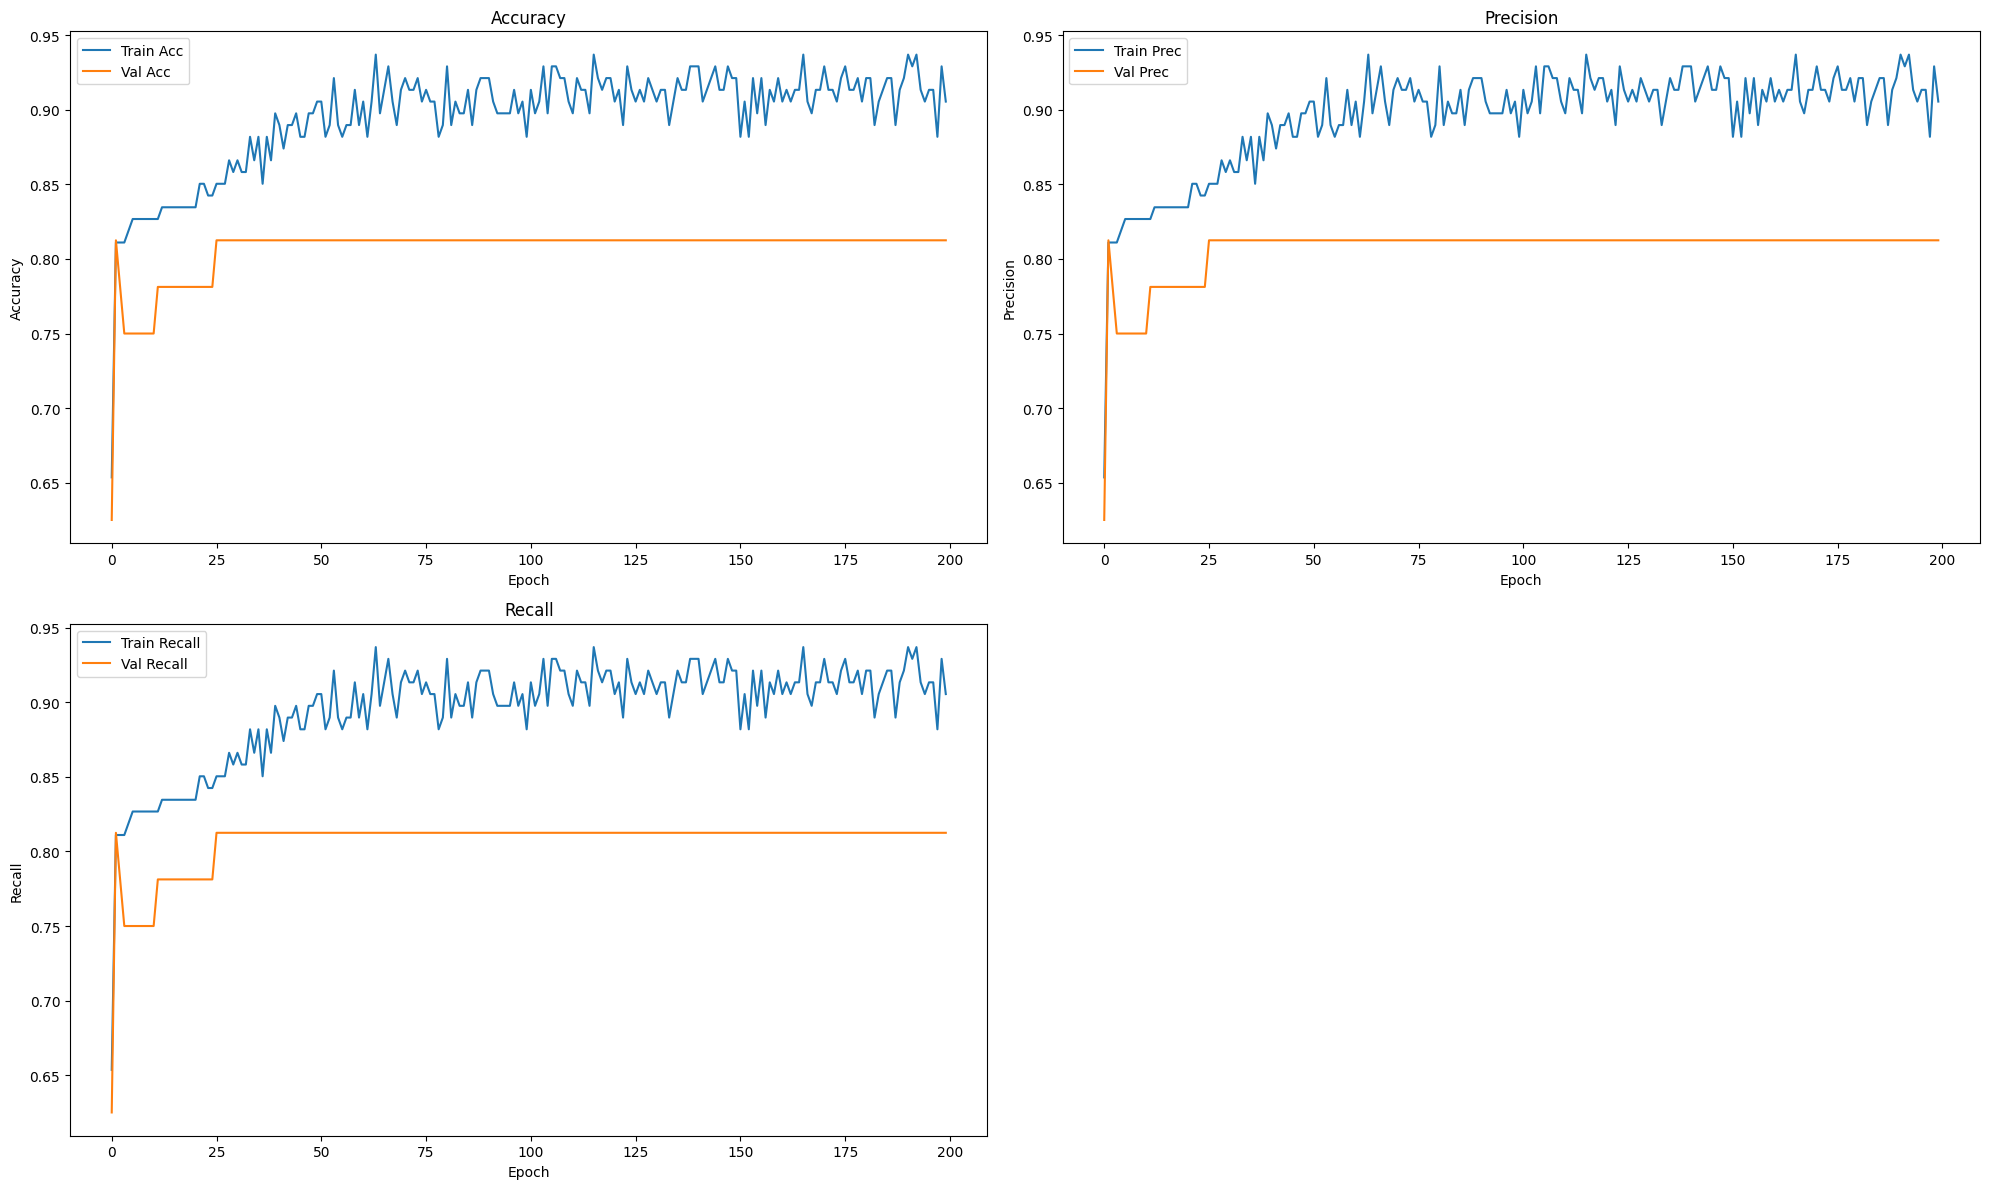

In [14]:
visualize(history= history)

## regression

In [15]:
from sklearn.model_selection import train_test_split

X_ehg_train, X_ehg_test, y_ehg_train, y_ehg_test = train_test_split(X_ehg, y_regression, test_size=0.2, random_state=42)
X_emr_train, X_emr_test, y_emr_train, y_emr_test = train_test_split(X_emr, y_regression, test_size=0.2, random_state=42)

In [16]:
from keras import layers, Model


class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, dilation_rate=1, dropout=0.0, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout

        # conv layers (causal padding)
        self.conv1 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.drop1 = layers.Dropout(dropout) if dropout > 0 else None

        self.conv2 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.drop2 = layers.Dropout(dropout) if dropout > 0 else None

        # residual add + final activation
        self.add_layer = layers.Add()
        self.final_act = layers.ReLU()

        # downsample will be created in build() only if needed
        self.downsample = None

    def build(self, input_shape):
        # input_shape: (batch, time, channels_in)
        channels_in = int(input_shape[-1])
        if channels_in != self.filters:
            # create 1x1 conv to match channels
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding="same", use_bias=False)
        else:
            # identity function (lambda)
            self.downsample = lambda x: x
        super().build(input_shape)

    def call(self, x, training=None):
        y = self.conv1(x)
        y = self.bn1(y, training=training)
        y = self.act1(y)
        if self.drop1 is not None:
            y = self.drop1(y, training=training)

        y = self.conv2(y)
        y = self.bn2(y, training=training)
        y = self.act2(y)
        if self.drop2 is not None:
            y = self.drop2(y, training=training)

        # residual path: downsample(x) if needed, else identity
        res = self.downsample(x)  # either a Layer or a lambda identity

        out = self.add_layer([res, y])
        return self.final_act(out)


class MultiInputModelTCN(Model):
    def __init__(self):
        super().__init__()

        # TCN branch for time series
        self.tcn1 = TCNBlock(filters=8, kernel_size=3, dilation_rate=1, dropout=0.1)
        self.tcn2 = TCNBlock(filters=16, kernel_size=3, dilation_rate=2, dropout=0.1)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.ts_dense = layers.Dense(16, activation="relu")

        # Tabular branch (MLP)
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # Combined MLP
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(1, activation=None)

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # TCN branch
        x1 = self.tcn1(ts_input, training=training)
        x1 = self.tcn2(x1, training=training)
        x1 = self.global_pool(x1)   # -> (batch, channels)
        x1 = self.ts_dense(x1)

        # Tabular branch
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # Combine
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
    
    def build(self, input_shape):
        super().build(input_shape)


In [51]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, Callback

# Hàm scheduler
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.8
    return lr

# Callback để log lr mỗi epoch
class LrLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr_obj = self.model.optimizer.learning_rate
        if hasattr(lr_obj, 'numpy'):
            lr = float(lr_obj.numpy())
        else:
            lr = float(tf.keras.backend.get_value(lr_obj))
        print(f"Epoch {epoch+1}: lr = {lr:.6f}")

lr_callback = LearningRateScheduler(scheduler, verbose=1)
log_callback = LrLogger()

In [52]:
model = MultiInputModelTCN()
model.compile(
    optimizer= keras.optimizers.Adam(0.01),
    loss="mse",        
    metrics=["mae", "mse"]
)

In [53]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    callbacks=[lr_callback, log_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 71034.5938 - mae: 266.1323 - mse: 71034.5938Epoch 1: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 63347.8711 - mae: 250.8341 - mse: 63347.8711 - val_loss: 49124.5469 - val_mae: 220.9011 - val_mse: 49124.5469 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 49459.6641 - mae: 221.3906 - mse: 49459.6641Epoch 2: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 36633.0781 - mae: 188.8495 - mse: 36633.0781 - val_loss: 12091.6055 - val_mae: 106.8831 - val_mse: 12091.6055 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 12011.0332 - mae: 106.6150 - mse: 12011.0332Epoch 3: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24

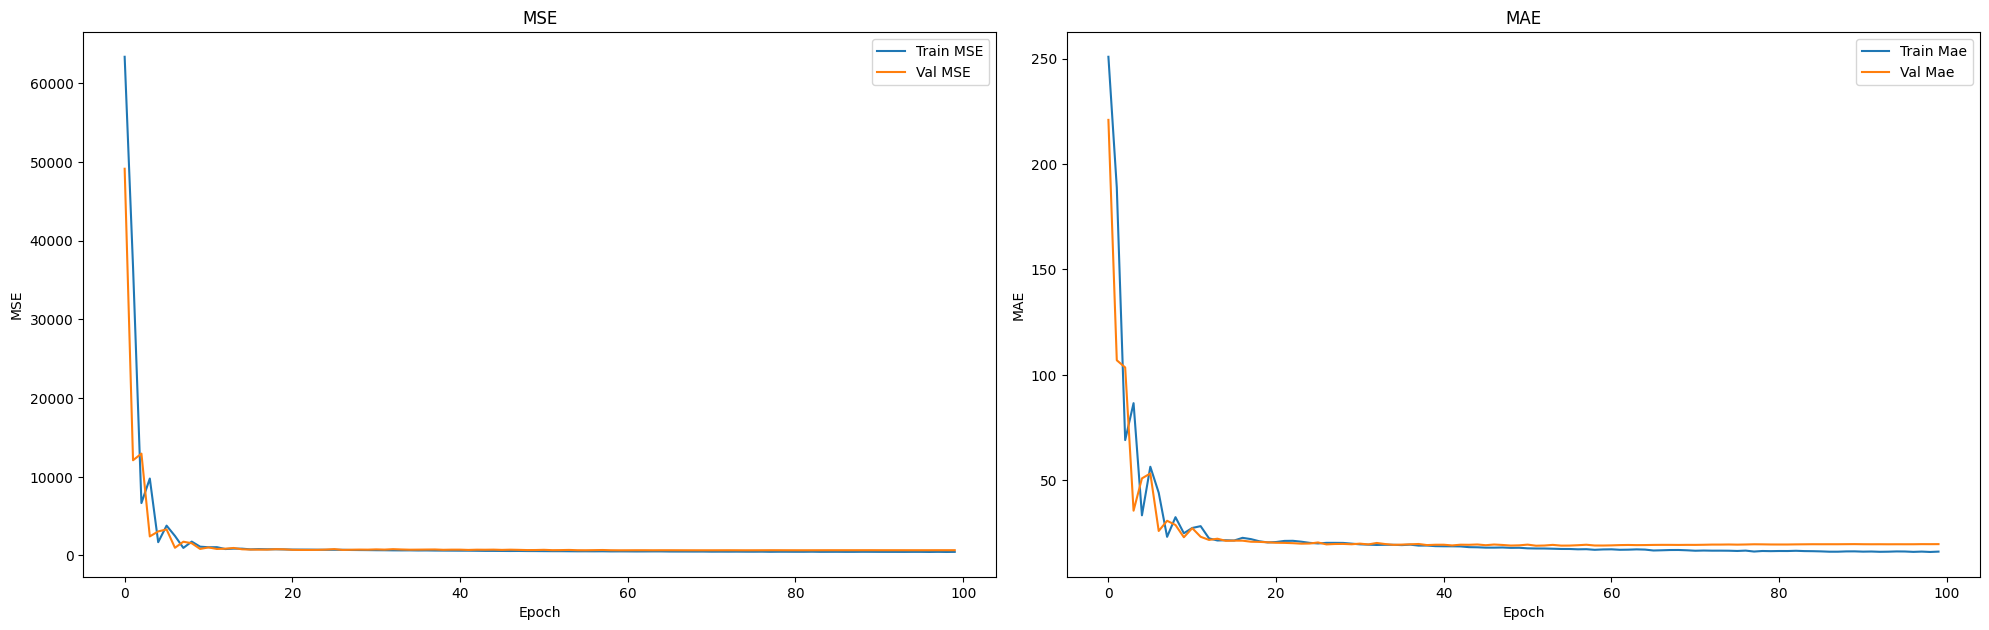

In [54]:
visualize2(history= history)

## LSTM

In [55]:
from keras import layers, Model
class BiLSTMBlock(layers.Layer):
    def __init__(self, units, dropout=0.0, return_sequences=True, name=None):
        super().__init__(name=name)
        self.units = units
        self.dropout_rate = dropout
        self.return_sequences = return_sequences

        # Bidirectional wrapper
        self.bilstm = layers.Bidirectional(
            layers.LSTM(units, dropout=dropout, return_sequences=return_sequences)
        )
        self.act = layers.ReLU()

    def call(self, x, training=None):
        y = self.bilstm(x, training=training)
        y = self.act(y)
        return y


class MultiInputModelLSTM(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # ======== BiLSTM branch for time series ========
        self.bilstm1 = BiLSTMBlock(units=32, dropout=0.1, return_sequences=True)
        self.bilstm2 = BiLSTMBlock(units=16, dropout=0.2, return_sequences=False)
        self.ts_dense = layers.Dense(16, activation="relu")

        # ======== Tabular branch (MLP) ========
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # ======== Combined MLP ========
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(1, activation=None)

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # --- Time series branch (BiLSTM) ---
        x1 = self.bilstm1(ts_input, training=training)
        x1 = self.bilstm2(x1, training=training)
        x1 = self.ts_dense(x1)

        # --- Tabular branch ---
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # --- Combine two branches ---
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)

    def build(self, input_shape):
        super().build(input_shape)


In [56]:
model = MultiInputModelLSTM(1)
model.compile(
    optimizer= keras.optimizers.Adam(0.01),
    loss="mse",        
    metrics=["mae", "mse"]
)

In [57]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    callbacks=[lr_callback, log_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 67390.7578 - mae: 258.8898 - mse: 67390.7578Epoch 1: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 62556.2305 - mae: 249.2878 - mse: 62556.2305 - val_loss: 47736.0195 - val_mae: 217.7437 - val_mse: 47736.0195 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 43528.4844 - mae: 207.2694 - mse: 43528.4844Epoch 2: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 38056.9688 - mae: 193.0380 - mse: 38056.9688 - val_loss: 17539.6641 - val_mae: 130.8291 - val_mse: 17539.6641 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 13060.3320 - mae: 107.3038 - mse: 13060.3320Epoch 3: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

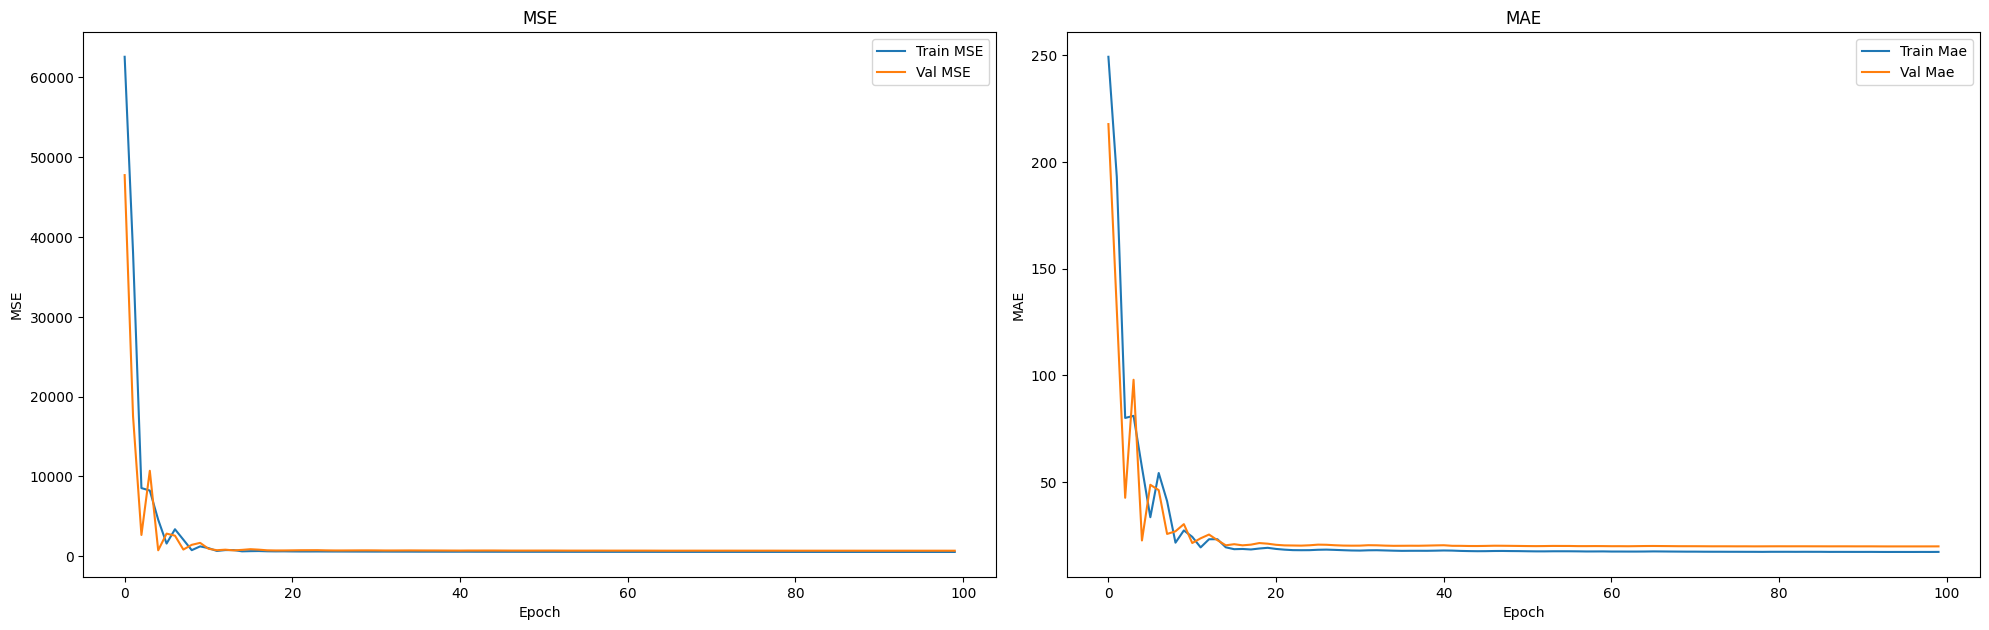

In [58]:
visualize2(history= history)